In [67]:
import numpy as np, pandas as pd
#from sklearn.cluster import DBSCAN
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors import KNeighborsClassifier

In [68]:
N_CAT = 30                     # number of places categories
WEIGHTS    = {"dislike": -3,
              "want to try": 1,
              "visited": 1,
              "fav": 2}
MIN_PLACES = 3                      # ignore users with less than 3 rated places
REDUCE_D   = 15                     # target dimension

In [69]:
# load embeddings 
places = pd.read_csv("places.csv") #import places csv
emb = np.stack(places['embedding'].apply(eval)) # change to arr

# compress for speed
pca_places = PCA(n_components=REDUCE_D, random_state=0).fit_transform(emb)

# perform clustering using KMeans technique
k30 = KMeans(N_CAT, random_state=0, n_init="auto").fit(pca_places)
places['cat_id'] = k30.labels_

In [70]:
# pca = PCA(n_components=REDUCE_D).fit_transform
C = k30.cluster_centers_
D = cosine_distances(pca_places, C)
k = 3           
nearest = np.argsort(D, axis=1)[:, :k]

rows = []
for pid, neigh in zip(places.place_id, nearest):
    for c in neigh:
        rows.append((pid, c))

# place the places into categories based on the top 3 closest matching clusters
place_to_cat = pd.DataFrame(rows, columns=["place_id", "cat_id"]) 

# create a new dataframe that has the user_id, place_if of visited/fav/disliked/saved place and the matching cat_id
user_to_cat = pd.read_csv("user_place.csv").merge(place_to_cat, on="place_id")
user_to_cat['w'] = user_to_cat['status'].map(WEIGHTS)

U_mat = (user_to_cat.groupby(['user_id', 'cat_id']).w.sum().unstack(fill_value=0).astype(float))

# drop users that have less than MIN_PLACES (3 in our case) ranked
U_mat = U_mat[U_mat.abs().sum(1) >= MIN_PLACES]

# normalize vectors
user_vector = U_mat.div(np.linalg.norm(U_mat, axis=1), axis=0).fillna(0)


In [71]:
# dim-reduce to dodge the curse of dimensionality
u_red = PCA(n_components=REDUCE_D, random_state=0).fit_transform(user_vector)

X = StandardScaler().fit_transform(u_red)

# run OPTICS
opt = OPTICS(min_samples=25, xi=0.05, min_cluster_size=0.02).fit(X)

user_vector['cluster'] = opt.labels_ 

Best k = 7.0, with RMSE = 0.0468

All results:
     k      rmse
0    1  0.058501
1    2  0.051043
2    3  0.048634
3    4  0.047626
4    5  0.047105
5    6  0.046894
6    7  0.046769
7    8  0.046809
8    9  0.047001
9   10  0.047101
10  11  0.047262
11  12  0.047439
12  13  0.047595
13  14  0.047817
14  15  0.047945
15  16  0.048171
16  17  0.048366
17  18  0.048556
18  19  0.048765
19  20  0.048960


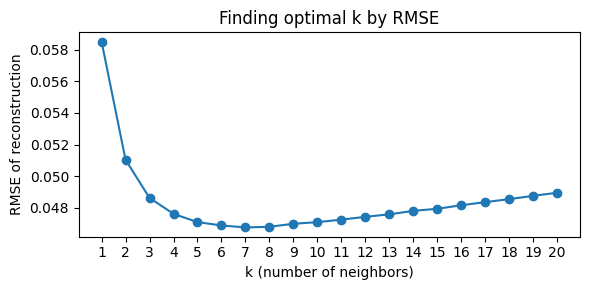

In [72]:
#  archetype features
feature_cols = list(range(30))
user_features = user_vector[feature_cols]
user_ids = user_features.index.to_numpy()
user_arr = user_features.to_numpy() 

# calculate rsme values of k = 1 - 20 to find best k-value
k_values = range(1, 21)  
rmse_list = []

for k in k_values:
    # fit NN model (we ask for k+1 because the first neighbor is the point itself)
    nn = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(user_arr)
    dists, idxs = nn.kneighbors(user_arr)
    
    # drop self-indices (first column)
    neigh_idxs = idxs[:, 1:]
    
    # predict each user as the mean of its k neighbors
    preds = np.stack([user_arr[neigh_idxs[i]].mean(axis=0)
                      for i in range(user_arr.shape[0])])
    
    # compute RMSE over all users & all 30 dims
    mse  = np.mean((user_arr - preds)**2)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)

results = pd.DataFrame({'k': k_values, 'rmse': rmse_list})
best = results.loc[results['rmse'].idxmin()]

print(f"Best k = {best.k}, with RMSE = {best.rmse:.4f}")
print("\nAll results:")
print(results)

# plot the line graph of different RSME for different k values we tested
plt.figure(figsize=(6,3))
plt.plot(results['k'], results['rmse'], marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('RMSE of reconstruction')
plt.title('Finding optimal k by RMSE')
plt.xticks(k_values)
plt.tight_layout()
plt.show() 

In [73]:
STOPWORDS = {"with", "or", "and", "a", "the", "of", "to", "in"}

# find each user’s top 7 nearest neighbors which we found is the most optimal using RSME
# we ask for 8 neighbors (self + k= 7) then drop the self
nbrs = NearestNeighbors(n_neighbors=8, metric='cosine').fit(user_arr)
dists, idxs = nbrs.kneighbors(user_arr)
neighbor_idxs = idxs[:, 1:]     # shape (n_users, 7)
neighbor_dists = dists[:, 1:]    # shape (n_users, 7)
neighbor_ids = user_ids[neighbor_idxs]

statuses = ["want to try", "visited", "fav"]
vis = (user_to_cat[user_to_cat['status'].isin(statuses)].merge(places[['place_id','key_words']], on='place_id', how='left'))
vis['kw_clean'] = (vis['key_words'].fillna("").astype(str).str.replace(r'[\[\]\{\}"\']', "", regex=True))

def extract_words(s: str):
    parts = [part.strip() for part in s.split(',') if part.strip()]

    #print(parts)
    words = []
    for part in parts:
        for token in part.lower().split():
            if token and token not in STOPWORDS:
                words.append(token)
    return words

vis['words'] = vis['kw_clean'].apply(extract_words)

# find top 5 words for each user
user_top5 = {}
for uid, grp in vis.groupby('user_id'):
    all_words = [w for sub in grp['words'] for w in sub]
    user_top5[uid] = [w for w,_ in Counter(all_words).most_common(5)]

# test users 1-20 and print their top words and their 7 closest neighbors' top words
for i in range(1,21):
    uid = f"user_{i}"
    if uid not in user_ids:
        print(f"{uid} not found\n")
        continue

    idx = np.where(user_ids == uid)[0][0]
    print(f"User: {uid}")
    print(f"User top-5 words: {user_top5.get(uid, [])}")

    for rank in range(7):
        nb = neighbor_ids[idx, rank]
        dist = neighbor_dists[idx, rank]
        print(f"  {rank+1}. Neighbor: {nb}  (cosine dist={dist:.3f})")
        print(f"    Neighbor top-5 words: {user_top5.get(nb, [])}")

    print("-" * 70)


User: user_1
User top-5 words: ['cafe', 'cozy', 'night', 'small', 'dinner']
  1. Neighbor: user_1003  (cosine dist=0.101)
    Neighbor top-5 words: ['cafe', 'date', 'pastries', 'night', 'coffee']
  2. Neighbor: user_400  (cosine dist=0.129)
    Neighbor top-5 words: ['cozy', 'cafe', 'night', 'pastries', 'date']
  3. Neighbor: user_58  (cosine dist=0.135)
    Neighbor top-5 words: ['cafe', 'date', 'night', 'pastries', 'cozy']
  4. Neighbor: user_474  (cosine dist=0.136)
    Neighbor top-5 words: ['night', 'date', 'cozy', 'authentic', 'lively']
  5. Neighbor: user_1151  (cosine dist=0.139)
    Neighbor top-5 words: ['cozy', 'italian', 'date', 'night', 'cafe']
  6. Neighbor: user_62  (cosine dist=0.149)
    Neighbor top-5 words: ['cozy', 'date', 'night', 'cafe', 'authentic']
  7. Neighbor: user_923  (cosine dist=0.157)
    Neighbor top-5 words: ['cozy', 'date', 'brunch', 'night', 'italian']
----------------------------------------------------------------------
User: user_2
User top-5 word

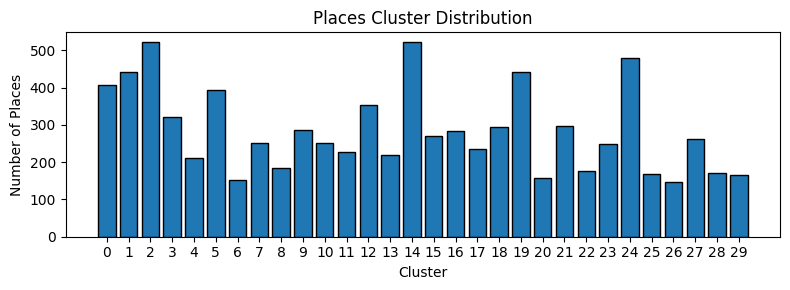

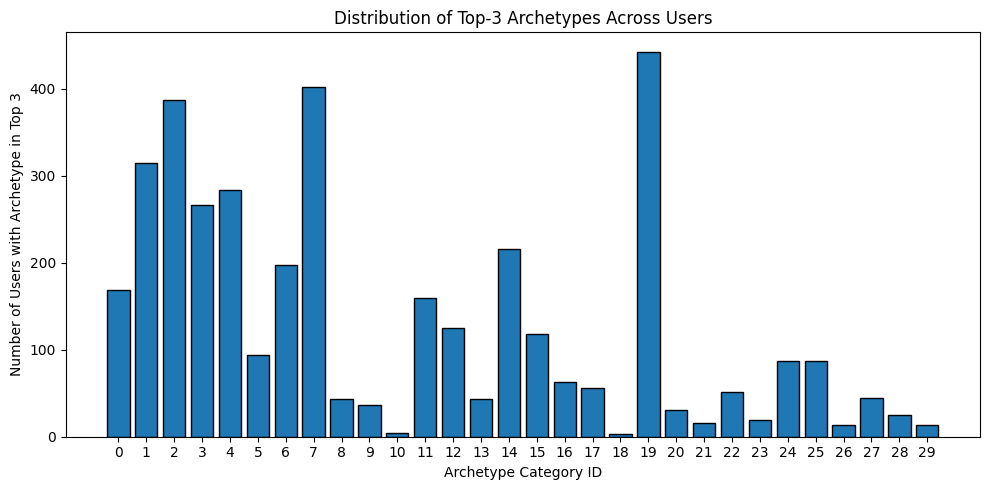

In [74]:
data = user_vector.drop(columns='cluster').values 
labels = user_vector['cluster'].values

# Bar chart of cluster sizes of places
unique, counts = np.unique(places["cat_id"], return_counts=True)
plt.figure(figsize=(8,3))
plt.bar(unique.astype(str), counts, edgecolor='black')
plt.title("Places Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Places")
plt.tight_layout()
plt.show()

# find top 3 archetypes the users belong to based on the weights of the clusters of each user
def return_largest(row):
    return row.T.nlargest(3).index.values

if "top_3" in user_vector.columns:
    user_vector["top_3"] = user_vector.drop("top_3", axis = 1).apply(return_largest, axis=  1)
else:
    user_vector["top_3"] = user_vector.apply(return_largest, axis=  1)

# plot the numbers of users that have a specific place cluster in their top 3 archetypes
exploded = user_vector.explode('top_3')
counts = exploded['top_3'].value_counts().sort_index()
plt.figure(figsize=(10,5))
plt.bar(counts.index.astype(str), counts.values, edgecolor='black')
plt.xlabel('Archetype Category ID')
plt.ylabel('Number of Users with Archetype in Top 3')
plt.title('Distribution of Top-3 Archetypes Across Users')
plt.tight_layout()
plt.show()